In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from snowflake.snowpark import Session
import darts
import json
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, ExponentialSmoothing, 
from darts.metrics import mape, 
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [2]:
credentials = json.load(open('secrets.json'))["SNOWFLAKE_CONNECTION"]
session = Session.builder.configs(credentials).create()
session.use_database("hackathon")
session.use_schema("public")
mdf = session.table("challenge1_train_data")
mdf = mdf.to_pandas()
mdf.columns = mdf.columns.str.lower()
mdf["date"] = pd.to_datetime(mdf["date"])
mdf.head()

,date,dc_name,size_code,retail_price,total_tires,zip_code
0,2022-02-05,OAKLAND,1856015,70.090,1,94604
1,2021-03-02,OAKLAND,1856015,59.090,1,94604
2,2020-12-08,OAKLAND,1856015,53.545,1,94604
3,2022-01-17,OAKLAND,1856015,58.410,1,94604
4,2020-11-13,OAKLAND,1856015,43.085,1,94604


In [3]:
mdf["month"] = mdf["date"].dt.month
mdf["year"] = mdf["date"].dt.year
mdf["quarter"] = mdf["date"].dt.quarter
mdf["weekday"] = mdf["date"].dt.weekday
mdf

,date,dc_name,size_code,retail_price,total_tires,zip_code,month,year,quarter,weekday
0,2022-02-05,OAKLAND,1856015,70.090,1,94604,2,2022,1,5
1,2021-03-02,OAKLAND,1856015,59.090,1,94604,3,2021,1,1
2,2020-12-08,OAKLAND,1856015,53.545,1,94604,12,2020,4,1
3,2022-01-17,OAKLAND,1856015,58.410,1,94604,1,2022,1,0
4,2020-11-13,OAKLAND,1856015,43.085,1,94604,11,2020,4,4
...,...,...,...,...,...,...,...,...,...,...
284695,2022-07-24,BAKERSFIELD,3512520,0.000,0,93308,7,2022,3,6
284696,2020-11-22,BAKERSFIELD,3512520,0.000,0,93308,11,2020,4,6
284697,2021-08-08,BAKERSFIELD,3512520,0.000,0,93308,8,2021,3,6
284698,2022-02-14,BAKERSFIELD,3512520,0.000,0,93308,2,2022,1,0


In [4]:
dfs = {name: frame for name, frame in mdf.groupby(["dc_name", "size_code"])}
dfs

{('BAKERSFIELD',
  1856015):              date      dc_name  size_code  retail_price  total_tires  \
 173740 2021-04-07  BAKERSFIELD    1856015        77.240            1   
 173741 2021-04-10  BAKERSFIELD    1856015        55.090            1   
 173742 2022-01-28  BAKERSFIELD    1856015         6.455            1   
 173743 2022-01-18  BAKERSFIELD    1856015        91.090            1   
 173744 2021-02-19  BAKERSFIELD    1856015        56.045            1   
 ...           ...          ...        ...           ...          ...   
 271160 2022-09-06  BAKERSFIELD    1856015         0.000            0   
 271161 2021-08-15  BAKERSFIELD    1856015         0.000            0   
 271162 2021-09-06  BAKERSFIELD    1856015         0.000            0   
 271163 2020-11-08  BAKERSFIELD    1856015         0.000            0   
 271164 2021-01-01  BAKERSFIELD    1856015         0.000            0   
 
         zip_code  month  year  quarter  weekday  
 173740     93308      4  2021        2    

<AxesSubplot:xlabel='date'>

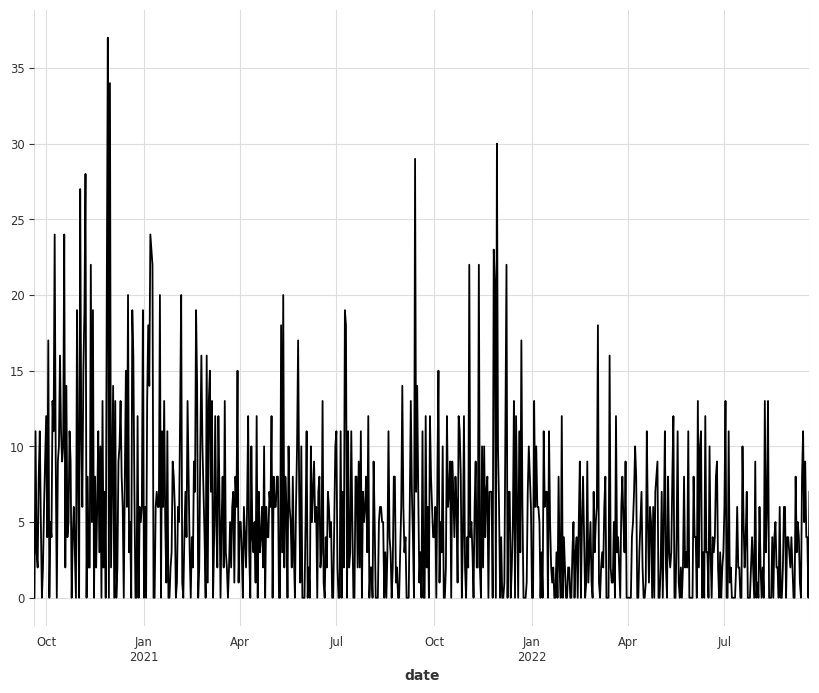

In [5]:
df = dfs[('BAKERSFIELD', 1856514)]
df.groupby("date")["total_tires"].sum().plot.line(figsize=(10, 8))

In [22]:
# Read data:
series = TimeSeries.from_dataframe(df, time_col="date", value_cols="total_tires", freq="D", fill_missing_dates=True)

# Create training and validation sets:
train, val = series.split_after(pd.Timestamp("20220701"))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
# Change name
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
series_scaled = scaler.transform(series)
train_scaled

<TimeSeries (DataArray) (date: 650, component: 1, sample: 1)>
array([[[0.        ]],

       [[0.2972973 ]],

       [[0.08108108]],

       [[0.05405405]],

       [[0.21621622]],

       [[0.2972973 ]],

       [[0.13513514]],

       [[0.        ]],

       [[0.05405405]],

       [[0.16216216]],

...

       [[0.10810811]],

       [[0.21621622]],

       [[0.24324324]],

       [[0.05405405]],

       [[0.        ]],

       [[0.08108108]],

       [[0.        ]],

       [[0.05405405]],

       [[0.08108108]],

       [[0.16216216]]])
Coordinates:
  * date       (date) datetime64[ns] 2020-09-20 2020-09-21 ... 2022-07-01
  * component  (component) object 'total_tires'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [1]:
model = TransformerModel(
    pl_trainer_kwargs={"accelerator": "gpu", "devices":[0]},
    input_chunk_length=12,
    output_chunk_length=1,
    batch_size=32,
    n_epochs=200,
    model_name="tire_transformer",
    nr_epochs_val_period=10,
    d_model=16,
    nhead=8,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    activation="relu",
    random_state=42,
    save_checkpoints=True,
    force_reset=True,
)

model

NameError: name 'TransformerModel' is not defined

In [18]:
model.fit(series=train_scaled, val_series=val_scaled, verbose=True)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

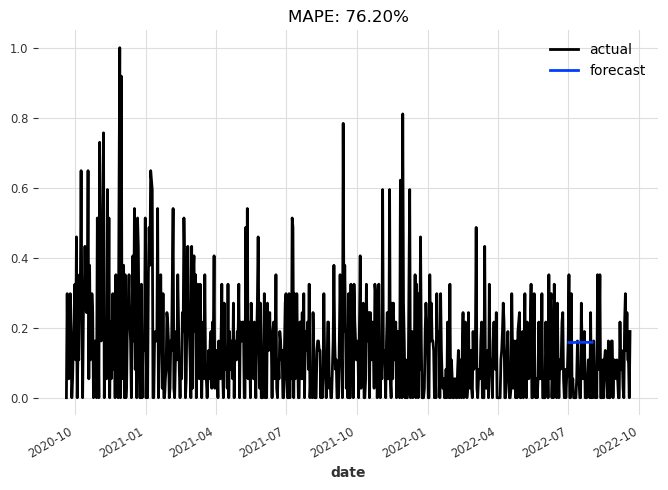

In [9]:
def eval_model(model, n, series, val_series):
    pred_series = model.predict(n=n)
    plt.figure(figsize=(8, 5))
    series.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_series)))
    plt.legend()

eval_model(model, 31, series_scaled, val_scaled)